# Compare Average Bubbles

In [3]:
import numpy as np
from numpy import load
import math
import matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt
import scipy as scp
import scipy.optimize as sco
import scipy.signal as scs
import scipy.special as ssp
import operator as op
import statistics as stat
from itertools import zip_longest, compress, count, islice, groupby, cycle, chain
import os
#import pywt
import scipy.ndimage
from scipy.ndimage import gaussian_filter1d, gaussian_filter
#import cv2
from PIL import Image

In [4]:
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

### Simulation Parameters 

In [5]:
nLat = 4096
nu = 2.*10**(-3)
lenLat = 2 * 50. / np.sqrt(2. * nu)
nyq = nLat//2+1
spec = nyq
hLat = nLat//2
dx = lenLat/nLat
dk = 2.*np.pi/lenLat

def source(ss):
    if ss == 'thin':
        # thin wall
        nSims = 390
        lamb = 6
        m2eff = 4. * nu * (- 1. + lamb**2)
        phi0 = 2. * np.pi / 7.
        V = lambda phi : (-np.cos(phi)+0.5*lamb**2.*np.sin(phi)**2.)*4.*nu
        instanton_location = '/home/dpirvu/inst/instantons/dev/thin_wall_instanton_sim.dat'
        sim_location = lambda sim: '/gpfs/dpirvu/sims/x'+str(nLat)+'_phi0{:.4f}'.format(phi0)+'_lambda{:.4f}'.format(lamb)+'_sim'+str(sim)+'_fields.dat'
        coleman_profile = np.pi+np.genfromtxt(instanton_location)[:,0] # theoretical bubble profile
        plots_file = '/home/dpirvu/big_plot_file/thin_wall_average_bubble/'
        pickle_location = '/home/dpirvu/pickle_location/thin_wall_average_bubble/old_'
        cutout_location = '/gpfs/dpirvu/thin_wall_average_bubble/'
        suffix = '_for_phi0{:.4f}'.format(phi0)+'_len{:.4f}'.format(lenLat)+'_lamb{:.4f}'.format(lamb)+'_x'+str(nLat)
    if ss == 'free':
        # thin wall
        nSims = 10
        lamb = 6
        m2eff = 4. * nu * (- 1. + lamb**2)
        phi0 = 2. * np.pi / 7.
        V = lambda phi : (-m2eff*phi)**2*4.*nu
        instanton_location = '/home/dpirvu/inst/instantons/dev/thin_wall_instanton_sim.dat'
        sim_location = lambda sim: '/gpfs/dpirvu/sims/free_x'+str(nLat)+'_phi0{:.4f}'.format(phi0)+'_lambda{:.4f}'.format(lamb)+'_sim'+str(sim)+'_fields.dat'
        coleman_profile = np.pi+np.genfromtxt(instanton_location)[:,0] # theoretical bubble profile
        plots_file = '/home/dpirvu/big_plot_file/free_field_peak_correlator/'
        pickle_location = '/home/dpirvu/pickle_location/free_field_peak_correlator/'
        cutout_location = '/gpfs/dpirvu/sims/'
        suffix = '_for_free_phi0{:.4f}'.format(phi0)+'_len{:.4f}'.format(lenLat)+'_x'+str(nLat)
    elif ss == 'thick':
        # thick wall
        nSims = 100
        lamb = 1.5
        m2eff = 4. * nu * (- 1. + lamb**2)
        phi0 = 2. * np.pi / 4.
        V = lambda phi : (-np.cos(phi)+0.5*lamb**2.*np.sin(phi)**2.)*4.*nu
        instanton_location = '/home/dpirvu/inst/instantons/dev/thick_wall_instanton_sim.dat'
        sim_location = lambda sim: '/gpfs/dpirvu/sims/x'+str(nLat)+'_phi0{:.4f}'.format(phi0)+'_lambda{:.4f}'.format(lamb)+'_sim'+str(sim)+'_fields.dat'
        coleman_profile = np.pi+np.genfromtxt(instanton_location)[:,0] # theoretical bubble profile
        plots_file = '/home/dpirvu/big_plot_file/thick_wall_average_bubble/'
        pickle_location = '/home/dpirvu/pickle_location/thick_wall_average_bubble/'
        cutout_location = '/gpfs/dpirvu/thick_wall_average_bubble/'
        suffix = '_for_phi0{:.4f}'.format(phi0)+'_lambda'+str(lamb)+'_len{:.4f}'.format(lenLat)+'_x'+str(nLat)
    elif ss == 'up':
        # upturned
        nSims = 100
        lamb = 6
        m2eff = 4. * nu * (- 1. + lamb**2)
        phi0 = 2. * np.pi / 7.
        phiMax = 1.59858
        AA = 10
        ppp = 3
        V = lambda x : np.piecewise(x, [x > phiMax, x <= phiMax], [lambda x: (-np.cos(x)+0.5*lamb**2.*np.sin(x)**2.)*4.*nu, lambda x: 4.*nu*(-np.cos(phiMax)+0.5*lamb**2*np.sin(phiMax)**2 + AA/ppp*np.abs(x-phiMax)**ppp)])
        instanton_location = '/home/dpirvu/inst/instantons/dev/thin_wall_instanton_sim.dat'
        sim_location = lambda sim: '/gpfs/dpirvu/sims/nonosc_x'+str(nLat)+'_phi0{:.4f}'.format(phi0)+'_lambda{:.4f}'.format(lamb)+'_sim'+str(sim)+'_fields.dat'
        coleman_profile = np.pi+np.genfromtxt(instanton_location)[:,0] # theoretical bubble profile
        plots_file = '/home/dpirvu/big_plot_file/non_osc_thin_wall_average_bubble/'
        pickle_location = '/home/dpirvu/pickle_location/non_osc_thin_wall_average_bubble/'
        cutout_location = '/gpfs/dpirvu/non_osc_thin_wall_average_bubble/'
        suffix = '_for_phi0{:.4f}'.format(phi0)+'_len{:.4f}'.format(lenLat)+'_lambda{:.4f}'.format(lamb)+'_x'+str(nLat)
    return nSims, lamb, m2eff, phi0, V, instanton_location, sim_location, coleman_profile, plots_file, pickle_location, cutout_location, suffix

titles = [r'$\phi(x)$', r'$\partial_t \phi(x)$', r'$|\nabla \phi(x)|^2$', r'$V(\phi(x))$']
def bubbles_file(min, max):
    return cutout_location+'bubbles_from_sim'+str(min)+'_up_to_sim'+str(max-1)+suffix+'.npy'
def centred_bubbles_file(min, max):
    return pickle_location+'centred_bubbles_from_sim'+str(min)+'_up_to_sim'+str(max-1)+suffix+'.npy'
def bubbles_at_rest_file(sim):
    return cutout_location+'restbubble_sim'+str(sim)+suffix+'.npy'
def average_bubble(min, max):
    return pickle_location+'average_bubble_from_sim'+str(min)+'_up_to_sim'+str(max-1)+suffix+'.npy'
def new_bubble_data(min, max):
    return pickle_location+'bubbles_sim'+str(min)+'_up_to_sim'+str(max-1)+suffix+'.npy'
def new_full_bubble_data(min, max):
    return cutout_location+'rest_bubbles_from_sim'+str(min)+'_up_to_sim'+str(max-1)+suffix+'.npy'
def average_of_N_bubbles(Nbubbles):
    return pickle_location+'average_of_'+str(Nbubbles)+'_bubbles'+suffix+'.npy'

def time_at_fraction(bubble, frac, limit):
    T, N = len(bubble), len(bubble[0])
    right_phi_x = [np.sum([1 for x in slice if x >= limit]) for slice in bubble]
    time_list = [t if (right_phi_x[t] <= N*frac) else 0 for t in range(T)]
    return next((t for t in time_list[::-1] if t != 0), 0)


<ipython-input-6-da70e0311c10>:6: PeakPropertyWarning: some peaks have a width of 0
  fwhm, height, left_ips, right_ips = scs.peak_widths(temp, peaks, rel_height=0.5)
<ipython-input-6-da70e0311c10>:6: PeakPropertyWarning: some peaks have a width of 0
  fwhm, height, left_ips, right_ips = scs.peak_widths(temp, peaks, rel_height=0.5)


filter_size =  173.7779557760698 0.3860202221885229
filter_size =  50.64720254541112 0.3860202221885229
filter_size =  173.7779557760698 0.3860202221885229


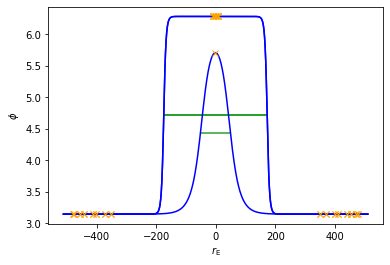

In [6]:
for test in ['thin', 'thick', 'up']: 
    nSims, lamb, m2eff, phi0, V, instanton_location, sim_location, coleman_profile, plots_file, pickle_location, cutout_location, suffix = source(test)
    xoffset = nLat//8
    temp = coleman_profile[len(coleman_profile)//2-xoffset:len(coleman_profile)//2+xoffset]
    peaks, _ = scs.find_peaks(temp)
    fwhm, height, left_ips, right_ips = scs.peak_widths(temp, peaks, rel_height=0.5)
    filter_size = max(fwhm)/2.; print('filter_size = ', filter_size, dx)
    radius_Coleman_bubble = filter_size*dx

    plt.plot(np.arange(len(temp))-xoffset, temp, color='b')
    plt.plot(peaks-xoffset, temp[peaks], "x", color='orange')
    [plt.hlines(height[i], left_ips[i]-xoffset, right_ips[i]-xoffset, color="C2") for i in range(len(fwhm))]
    plt.xlabel(r'$r_{\rm E}$'); plt.ylabel(r'$\phi$')

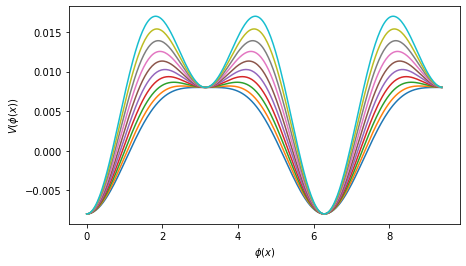

In [7]:
fig = plt.figure(figsize=(7, 4))
plt.xlabel(r'$\phi(x)$'); plt.ylabel(r'$V(\phi(x))$')
for lm in np.linspace(1, 2, 10):
    V = lambda phi : (-np.cos(phi)+0.5*lm**2.*np.sin(phi)**2.)*4.*nu
    plt.plot([i for i in np.arange(0, 3*np.pi, np.pi/100)], [V(i) for i in np.arange(0, 3*np.pi, np.pi/100)])

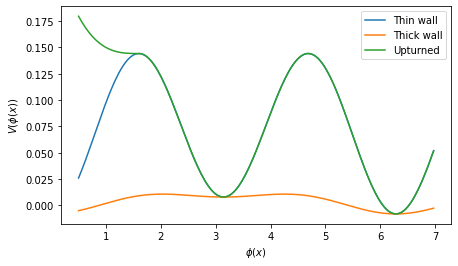

In [8]:
title_list = [r'Thin wall', r'Thick wall', r'Upturned']
fig = plt.figure(figsize=(7, 4))
plt.xlabel(r'$\phi(x)$'); plt.ylabel(r'$V(\phi(x))$')
for kkk, test in enumerate(['thin', 'thick', 'up']): 
#for test in ['thick']:
    nSims, lamb, m2eff, phi0, V, instanton_location, sim_location, coleman_profile, plots_file, pickle_location, cutout_location, suffix = source(test)
    right_phi_at_V_max = sco.minimize_scalar(lambda x: -V(x), bounds=[np.pi, 2*np.pi], method='bounded')
    left_phi_at_V_max = sco.minimize_scalar(lambda x: -V(x), bounds=[0, np.pi], method='bounded')
    plt.plot([i for i in np.arange(0.5, 7, np.pi/100)], [V(i) for i in np.arange(0.5, 7, np.pi/100)], label=title_list[kkk])
plt.legend()

### Load Data 

In [9]:
#for ss in ['thin', 'thick', 'up']:
for ss in ['thin']:
    nSims, lamb, m2eff, phi0, V, instanton_location, sim_location, coleman_profile, plots_file, pickle_location, cutout_location, suffix = source(ss)
    # load data
    if ss == 'thin':
        ab, error_ab = np.load(average_bubble(0, nSims))
        newBubbleData = np.load(new_bubble_data(0, nSims))
#        newfullBubbleData = np.load(new_full_bubble_data(0, int(nSims/2)))
    else:
        ab, error_ab = np.load(average_bubble(0, nSims))
        newBubbleData = np.load(new_bubble_data(0, nSims))
#        newfullBubbleData = np.load(new_full_bubble_data(0, nSims))

    # separate average bubble data
#    bubble, mom_bubble, ge_bubble, pe_bubble, ke_bubble = ab
#    error_bubble, error_mom_bubble, error_ge_bubble, error_pe_bubble, error_ke_bubble = error_ab

### Oscillon Detection 

In [8]:
if False:
    for bubble in newBubbleData[::15]:
        bubble = bubble[:time_at_fraction(bubble, 0.1, 4)]
        bubble = bubble-np.mean(bubble)
        # Free field power spectrum
    #    PSFilter = np.fft.ifft([(1/phi0/np.sqrt(2*lenLat))**2 / ((k*dk)**2. + m2eff)**0.5 for k in range(len(bubble[0]))])
    #    PSFilter = np.fft.fft(PSFilter/np.sum(PSFilter))
    #    bubble = [np.fft.ifft(np.fft.fft(slice)*PSFilter).real for slice in bubble]

        w = np.fft.fftfreq(np.shape(bubble)[0])
        FD = np.fft.fft(bubble, axis = 0)
        FD[w<=0,:]=0
        FD[w>0,:]*=2
        HD = np.fft.ifft(FD, axis = 0)

        fig, ax = plt.subplots(1, 2, figsize=(12,4))
        im1 = ax[0].imshow(bubble, aspect='auto', interpolation='none', origin='lower')
        im2 = ax[1].imshow(np.abs(HD), aspect='auto', interpolation='none', origin='lower')
        clb = plt.colorbar(im1, ax = ax[0])
        clb = plt.colorbar(im2, ax = ax[1])

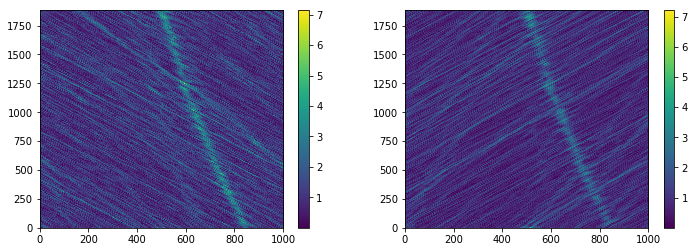

In [10]:
bubble = newBubbleData[0]
bubble = bubble[:time_at_fraction(bubble, 0.1, 4)]
bubble = bubble-np.mean(bubble)

tw = np.fft.fftfreq(np.shape(bubble)[0])
xw = np.fft.fftfreq(np.shape(bubble)[1])
tFD = np.fft.fft(bubble, axis = 0)
xFD = np.fft.fft(bubble, axis = 1)
xFD[:,xw<0] = 0
xFD[:,xw>0] *= 2
tFD[tw<0,:] = 0
tFD[tw>0,:] *= 2
tHD = np.fft.ifft(tFD, axis = 0)
xHD = np.fft.ifft(xFD, axis = 1)

lFD = np.fft.fft(tHD, axis = 1)
rFD = np.fft.fft(xHD, axis = 0)
lFD[:,xw<0] = 0
lFD[:,xw>0] *= 2
rFD[tw>0,:] = 0
rFD[tw<0,:] *= 2
lHD = np.fft.ifft(lFD, axis = 1)
rHD = np.fft.ifft(rFD, axis = 0)

fig, ax = plt.subplots(1, 2, figsize=(12,4))
im1 = ax[0].imshow(np.abs(lHD), aspect='auto', interpolation='none', origin='lower')
im2 = ax[1].imshow(np.abs(rHD), aspect='auto', interpolation='none', origin='lower')
plt.colorbar(im1, ax = ax[0]); plt.colorbar(im2, ax = ax[1])

In [15]:
T, N = len(bubble), len(bubble[0]); print(T, N)

w = np.fft.fftfreq(np.shape(bubble)[0])
FD = np.fft.fft(bubble, axis = 0)
FD[w<=0,:]=0
FD[w>0,:]*=2
HD = np.fft.ifft(FD, axis = 0)

aHD = np.abs(HD)
aHD = np.asarray([gaussian_filter1d(i, sigma=10) for i in aHD])

amp = 4
t = aHD**amp/np.sum(aHD**amp, axis=1)[:,None] 
SB = t*np.arange(N)[None,:]
xt = np.sum(SB, axis=1)

1882 1000


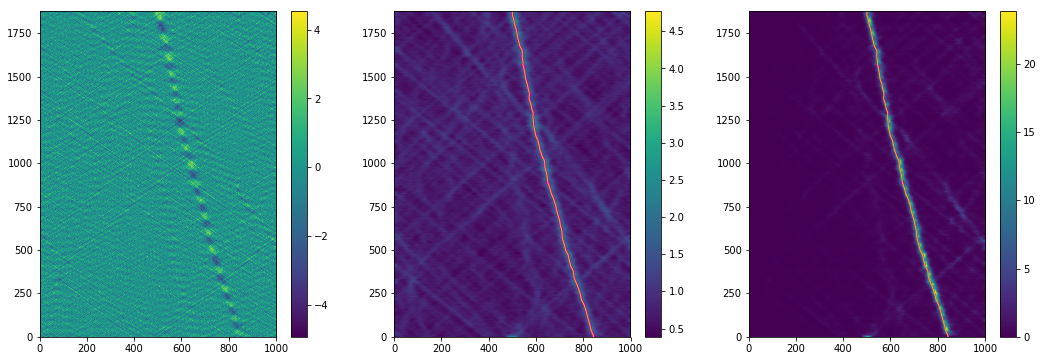

In [16]:
def get_HT(array):  
    array = array-np.mean(array)
    w = np.fft.fftfreq(np.shape(array)[0])
    FD = np.fft.fft(array, axis = 0)
    FD[w<=0,:]=0
    FD[w>0,:]*=2
    HD = np.fft.ifft(FD, axis = 0)
    return np.abs(HD)

def get_osc_trajectory(array, extent):
    # find maximum value in array
    flattened = chain.from_iterable(array)
    max_idx, max_val = max(enumerate(flattened), key=op.itemgetter(1))
    row = max_idx // N
    col = max_idx % N
#    print(array[row][col] == max_val, max_val, array[row][col], row, col)
#    ax[axis].plot(col, row, 'ro', ms=10)

    # use as starting point for oscillon trajectory
#    print(col, row)
    maxLine = []
    CCol = col
    for rr in range(row)[::-1]:
        if rr == row-1:
            col = CCol
        colmin = col - extent
        colmax = col + extent+1
        val = 0
        for cc in range(colmin, colmax):
            cc = cc%N
            if array[rr][cc] > val:
                val = array[rr][cc]
                col = cc
        maxLine.append(col)
    maxLine = maxLine[::-1]
    for rr in range(row, T):
        if rr == row:
            col = CCol
        colmin = col - extent
        colmax = col + extent+1
        val = 0
        for cc in range(colmin, colmax):
            cc = cc%N
            if array[rr][cc] > val:
                val = array[rr][cc]
                col = cc
        maxLine.append(col)
    return maxLine

fig, ax = plt.subplots(1, 3, figsize=(18,6))
im1 = ax[0].imshow(HD.real, aspect='auto', interpolation='none', origin='lower') #original
im2 = ax[1].imshow(aHD, aspect='auto', interpolation='none', origin='lower') #hilbert transform amplitude
# power spectrum method
im3 = ax[2].imshow(SB, aspect='auto', interpolation='none', origin='lower') #power spectrum

maxLine1 = get_osc_trajectory(aHD, extent=10)
ax[1].plot(maxLine1, np.arange(T), 'm', linewidth='2')
maxLine1 = gaussian_filter1d(maxLine1, sigma=10)
ax[1].plot(maxLine1, np.arange(T), 'orange', linewidth='1')

maxLine2 = get_osc_trajectory(SB, extent=10)
ax[2].plot(maxLine2, np.arange(T), 'm', linewidth='1')
maxLine2 = gaussian_filter1d(maxLine2, sigma=10)
ax[2].plot(maxLine2, np.arange(T), 'orange', linewidth='1')

plt.colorbar(im1, ax = ax[0]); plt.colorbar(im2, ax = ax[1]); plt.colorbar(im3, ax = ax[2])

In [17]:
# construct oscillon trajectory from alg above
listcoords = maxLine1
oscillonTraj = np.asarray([[i,j] for i,j in zip(np.arange(T), listcoords)])
# field value along trajectory
oscillonAmp = [bubble[i][j] for i,j in zip(oscillonTraj[:,0], oscillonTraj[:,1])]

# wavelet transform on oscillon maplitude
C,B     = 1,1 # center, bandwidth # C = freq to investigate, B = bandwidth
wavelet = "cmor%f_%f"%(C,B)
dt      = 1
scales  = np.arange(1,256)
CC, f   = pywt.cwt(oscillonAmp, scales, wavelet, sampling_period=dt)

fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(15, 2*4),gridspec_kw=dict(hspace=0),sharex=True)
ax1.imshow(np.abs(CC), aspect='auto', interpolation='none', origin='lower')
# plot field value along trajectory
ax2.plot(oscillonAmp)
ax2.plot(gaussian_filter1d(oscillonAmp, sigma=10))

NameError: name 'pywt' is not defined

### FT of Oscillon Signal

In [185]:
saveTFreqs, saveTPS, oscillonAmp = [], [], []
for bubble in newBubbleData[::]:
    tcut = time_at_fraction(bubble, 0.1, 4) # cut out bubble to get good background average
    bubble = bubble[tcut-1000:tcut]
    if len(bubble) < 500:
        continue
    bubble = bubble-np.mean(bubble)
    
    # smoothen using free field power spectrum as window
    bubble = [np.fft.ifft(np.fft.fft(slice)*PSFilter[:len(bubble[0])]).real for slice in bubble]

    aHD = get_HT(bubble)
    aHD = np.asarray([gaussian_filter1d(i, sigma=10) for i in aHD])
    T, N = len(bubble), len(bubble[0])

    maxLine = get_osc_trajectory(aHD, extent=10)

    # construct oscillon trajectory from alg above
    listcoords = gaussian_filter1d(maxLine, sigma=10)
    oscillonTraj = np.asarray([[i,j] for i,j in zip(np.arange(T), listcoords)])
    # field value along trajectory
    oscillonAmp.append([bubble[i][j] for i,j in zip(oscillonTraj[:,0], oscillonTraj[:,1])])
    
    avOscillon = np.fft.fft(oscillonAmp[-1])
    PS = np.conj(avOscillon)*avOscillon
    coords = np.argwhere(PS>1e4) # separate freqs where there is large field response
    freqs = np.fft.fftfreq(len(avOscillon), d=1) # get frequencies; d = x space units
    freqs = [freqs[i]*len(avOscillon) for i in range(len(freqs)) if i in coords]
    PS = [PS[i].real for i in range(len(PS)) if i in coords]
    saveTFreqs.append(np.asarray(freqs))
    saveTPS.append(np.asarray(PS))

Text(0.5, 0, '$\\omega$')

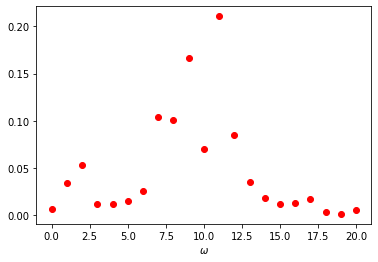

In [186]:
# flat list of all frequencies where response is strong
allTFreqs = np.asarray([item for sublist in saveTFreqs for item in sublist])
allTPS = np.asarray([item for sublist in saveTPS for item in sublist])

# cut duplicates
Tfreqsset = []
for i in allTFreqs:
    if np.abs(i) not in Tfreqsset:
        Tfreqsset.append(np.abs(i))
TPSamp = [0]*len(Tfreqsset)

# add field responses to get relative importance of each mode
for i in range(len(allTFreqs)):
    ind = Tfreqsset.index(np.abs(allTFreqs[i]))
    TPSamp[ind] += allTPS[ind]
TPSamp = TPSamp/np.sum(TPSamp)

# plot frequency vs response; plot mass from frequency and compare with free mass
plt.plot(Tfreqsset, TPSamp, 'ro'); plt.xlabel(r'$\omega$')
#plt.xlim((-1,21))

##### FT in space 

In [24]:
saveXFreqs, saveXPS = [], []
for bubble in newBubbleData[::]:
    tcut = time_at_fraction(bubble, 0.1, 4)
    bubble = bubble[tcut-500:tcut]
    if len(bubble) < 500:
        continue
    bubble = bubble-np.mean(bubble)
    bubble = [np.fft.ifft(np.fft.fft(slice)*PSFilter[:len(bubble[0])]).real for slice in bubble]

    for slice in bubble:
        slice = np.fft.fft(slice)
        PS = np.conj(slice)*slice
        coords = np.argwhere(PS>1e4)
        freqs = np.fft.fftfreq(len(slice), d=1) # get frequencies; d = x space units
        freqs = [freqs[i]*len(slice) for i in range(len(freqs)) if i in coords]
        PS = [PS[i].real for i in range(len(PS)) if i in coords]
        saveXFreqs.append(np.asarray(freqs))
        saveXPS.append(np.asarray(PS))

Text(0.5, 0, '$k$')

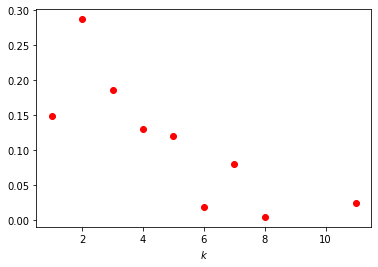

In [191]:
# flat list of all frequencies where response is strong
allXFreqs = np.asarray([item for sublist in saveXFreqs for item in sublist])
allXPS = np.asarray([item for sublist in saveXPS for item in sublist])

# cut duplicates
Xfreqsset = []
for i in allXFreqs:
    if np.abs(i) not in Xfreqsset:
        Xfreqsset.append(np.abs(i))
XPSamp = [0]*len(Xfreqsset)

# add field responses to get relative importance of each mode
for i in range(len(allXFreqs)):
    ind = Xfreqsset.index(np.abs(allXFreqs[i]))
    XPSamp[ind] += allXPS[ind]
Xfreqsset = Xfreqsset[1:]
XPSamp = XPSamp[1:]/np.sum(XPSamp[1:])

# plot frequency vs response; plot mass from frequency and compare with free mass
plt.plot(Xfreqsset, XPSamp, 'ro'); plt.xlabel(r'$k$')

/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


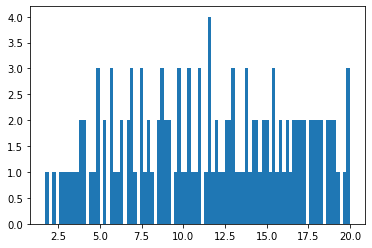

In [250]:
Xfreqsset = np.asarray(np.sort(Xfreqsset))
Tfreqsset = np.asarray(np.sort(Tfreqsset))
masses = np.outer(np.zeros(len(Xfreqsset)), np.zeros(len(Tfreqsset)))
for ii in range(len(masses)):
    for jj in range(len(masses[ii])):
        masses[ii][jj] = np.sqrt(Tfreqsset[jj]**2. - Xfreqsset[ii]**2.)
masses = masses.flatten()
masses.sort()
masses = [i for i in masses if i]
hist = plt.hist(masses, bins=int(len(masses)//2))

### Average Oscillon Signal

In [18]:
if False:
    oscillonAmp, oscillonWT = [], []
    for bubble in newBubbleData[::]:
        tcut = time_at_fraction(bubble, 0.1, 4)
        bubble = bubble[tcut-800:tcut]
        if len(bubble) < 500:
            continue
        bubble = bubble-np.mean(bubble, axis=0)
        bubble = [np.fft.ifft(np.fft.fft(slice)*PSFilter[:len(bubble[0])]).real for slice in bubble]

        aHD = get_HT(bubble)
        aHD = np.asarray([gaussian_filter1d(i, sigma=10) for i in aHD])
        T, N = len(bubble), len(bubble[0])

        maxLine = get_osc_trajectory(aHD, extent=10)
        maxLine = gaussian_filter1d(maxLine, sigma=10)

        # construct oscillon trajectory from alg above
        listcoords = maxLine
        oscillonTraj = np.asarray([[i,j] for i,j in zip(np.arange(T), listcoords)])
        # field value along trajectory
        oscillonAmp.append([bubble[i][j] for i,j in zip(oscillonTraj[:,0], oscillonTraj[:,1])])

        avOscillon = oscillonAmp[-1]
        # wavelet transform on oscillon maplitude
        C,B     = 0.5,1 # center, bandwidth # C = freq to investigate, B = bandwidth
        wavelet = "cmor%f_%f"%(C,B)
        dt      = 1
        scales  = np.arange(1,256)
        CC, f   = pywt.cwt(avOscillon, scales, wavelet, sampling_period=dt)
        oscillonWT.append(CC)

    #    fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(15, 2*2),gridspec_kw=dict(hspace=0),sharex=True)
    #    ax1.imshow(np.abs(CC), aspect='auto', interpolation='none', origin='lower')
    #    # plot field value along trajectory
    #    ax2.plot(avOscillon)
    #    ax2.plot(np.arange(len(avOscillon)), gaussian_filter1d(avOscillon, sigma=10), color='green')
    #    ax1.set_ylabel('f'); ax2.set_xlabel('t'); ax2.set_ylabel(r'$\phi(osc,t)$'); plt.show()

Text(0, 0.5, '$\\phi(osc,t)$')

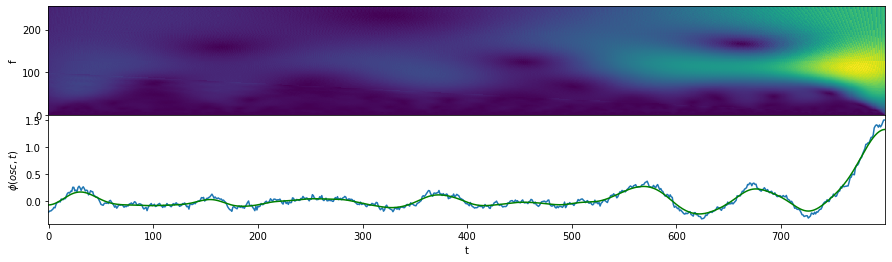

In [179]:
# average oscillon trajectories
def tolerant_mean(arrs):
    lens = [len(i) for i in arrs]
    arr = np.ma.empty((np.max(lens),len(arrs)))
    arr.mask = True
    for idx, l in enumerate(arrs):
        arr[:len(l),idx] = l
    return arr.mean(axis = -1), arr.std(axis=-1)

avOscillon = [jj[::-1] for jj in oscillonAmp]
avOscillon, error = tolerant_mean(avOscillon)
avOscillon, error = avOscillon[::-1], error[::-1]
avWT = np.mean(oscillonWT, axis=0)

fig, ax = plt.subplots(2, 1, figsize=(15, 2*2),gridspec_kw=dict(hspace=0),sharex=True)
ax[0].imshow(np.abs(avWT), aspect='auto', interpolation='none', origin='lower')
# plot field value along trajectory
ax[1].plot(np.arange(T), avOscillon)
ax[1].plot(np.arange(T), gaussian_filter1d(avOscillon, sigma=10), ms=1, color='green')
ax[0].set_ylabel('f'); ax[1].set_xlabel('t'); ax[1].set_ylabel(r'$\phi(osc,t)$')

### Dispersion Relation and Mass 

In [10]:
#for ss in ['free']:
##for ss in ['thin']:
#    nSims, lamb, m2eff, phi0, V, instanton_location, sim_location, coleman_profile, plots_file, pickle_location, cutout_location, suffix = source(ss)
#    for sim in range(1,2): # for 'thin' simulation 1 is late time only
#        simulation = np.genfromtxt(sim_location(sim))
#        nT = len(simulation)//nLat
#        simulation_free = np.reshape(simulation, (nT, nLat))
##        simulation_bubble = np.reshape(simulation, (nT, nLat))

#       fig, ax = plt.subplots(1, 1, figsize=(6, 5))
#        plt.imshow(simulation_free, aspect='auto', interpolation='none', origin='lower')
##        plt.imshow(simulation_bubble, aspect='auto', interpolation='none', origin='lower')

In [11]:
nLat = 4096
nu = 2.*10**(-3)
lenLat = 2 * 50. / np.sqrt(2.*nu)
nyq = nLat//2+1
spec = nyq
hLat = nLat//2
dx = lenLat/nLat
dk = 2.*np.pi/lenLat
lamb = 6.
m2eff = 4. * nu * (- 1. + lamb**2)

# units
alpha = 8.
dk = 2.*np.pi/lenLat
dt = dx/alpha
dtout = dt*alpha

In [12]:
samples = np.load('samples.npy')

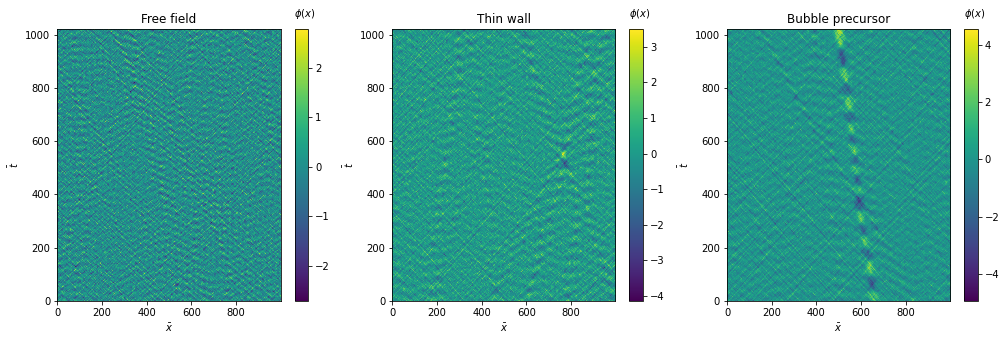

In [13]:
freefield, bubble, oscillon = samples
vec_photo = [freefield, bubble, oscillon]

bT, bN = min(len(freefield), len(oscillon)), min(len(freefield[0]), len(oscillon[0]))

title_list = ['Free field', 'Thin wall', 'Bubble precursor']
fig, ax = plt.subplots(1, 3, figsize=(17, 5))
for i in range(len(ax)):
    im = ax[i].imshow(vec_photo[i], aspect='auto', interpolation='none', origin='lower')
    clb = plt.colorbar(im, ax = ax[i])
    clb.set_label(r'$\phi(x)$', labelpad=-25, y=1.08, rotation=0)
    ax[i].set_xlabel(r'$\bar{x}$')
    ax[i].set_ylabel(r'$\bar{t}$')
    ax[i].set_title(title_list[i])
plt.show()

In [14]:
freePS = np.abs(np.fft.fftshift(np.fft.fft2(freefield)))**2.
bubblePS = np.abs(np.fft.fftshift(np.fft.fft2(bubble)))**2.
oscPS = np.abs(np.fft.fftshift(np.fft.fft2(oscillon)))**2.

kk = np.fft.fftshift(np.fft.fftfreq(bN,d=dx))
oo = np.fft.fftshift(np.fft.fftfreq(bT,d=dtout))
KK, OO = np.meshgrid(kk,oo)

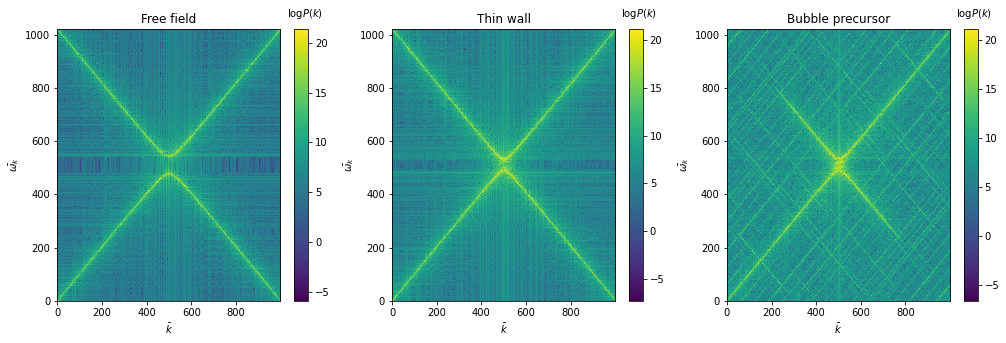

In [15]:
samples = [freePS, bubblePS, oscPS]
title_list = ['Free field', 'Thin wall', 'Bubble precursor']
fig, ax = plt.subplots(1, 3, figsize=(17, 5))
for i in range(len(ax)):
    im = ax[i].imshow(np.log(samples[i]), aspect='auto', interpolation='none', origin='lower')
    clb = plt.colorbar(im, ax = ax[i])
    clb.set_label(r'$\log P(k)$', labelpad=-25, y=1.08, rotation=0)
    ax[i].set_xlabel(r'$\bar{k}$')
    ax[i].set_ylabel(r'$\bar{\omega_k}$')
    ax[i].set_title(title_list[i])
plt.show()

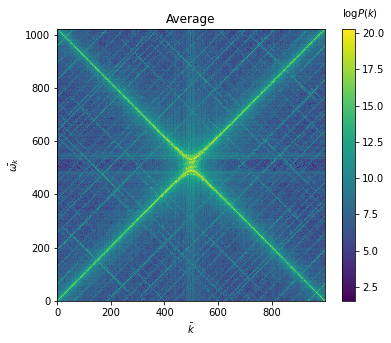

In [16]:
image = np.log(np.mean(samples, axis=0))
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
for i in range(1):
    im = ax.imshow(image, aspect='auto', interpolation='none', origin='lower')
    clb = plt.colorbar(im, ax = ax)
    clb.set_label(r'$\log P(k)$', labelpad=-25, y=1.08, rotation=0)
    ax.set_xlabel(r'$\bar{k}$')
    ax.set_ylabel(r'$\bar{\omega_k}$')
    ax.set_title('Average')
plt.show()

In [17]:
maxVal = np.mean(image) + 5*np.std(image)

# pairs (\omega_k, k)
free_coords = np.argwhere(np.log(freePS)>maxVal)
osc_coords = np.argwhere(np.log(oscPS)>maxVal)

kk2 = (kk[free_coords[:,1]])**2.
oo2 = (oo[free_coords[:,0]])**2.
kkkk2 = kk[osc_coords[:,1]]**2.
oooo2 = oo[osc_coords[:,0]]**2.

#maxima only
#kk2 = kk**2
#oo2 = oo[np.argmax(freePS,axis=0)]**2
#kkkk2 = kk**2
#oooo2 = oo[np.argmax(oscPS,axis=0)]**2

0.5291502622129182


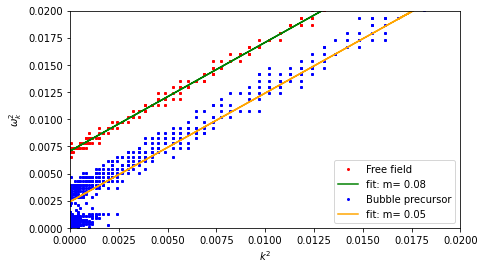

In [18]:
# fit to k^2  + m^2= o^2
def omega(k, a, m):
    return a*k + m**2

popt1, pcov1 = sco.curve_fit(omega, kk2, oo2)
#popt2, pcov2 = sco.curve_fit(omega, kkk2, ooo2)
popt3, pcov3 = sco.curve_fit(omega, kkkk2, oooo2)

print(np.sqrt(m2eff))
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
plt.plot(kk2, oo2, 'ro', ms=2, label='Free field')
plt.plot(kk2, omega(kk2, *popt1), 'g-', label='fit: m=%5.2f'%popt1[-1])#a=%5.3f, m=%5.3f' % tuple(popt1))

#plt.plot(kk, np.sqrt(omega(kk**2,*popt1)), color='m', label='fit: m=%5.2f'%popt1[-1])
#plt.plot(kk, np.sqrt(omega(kk**2,*popt3)), color='b', label='fit: m=%5.2f'%popt3[-1])    

plt.plot(kkkk2, oooo2, 'bo', ms=2, label='Bubble precursor')
plt.plot(kkkk2, omega(kkkk2, *popt3), color='orange', linestyle='-', label='fit: m=%5.2f'%popt3[-1])#a=%5.3f, m=%5.3f' % tuple(popt2))

plt.xlim((0,0.02))
plt.ylim((0,0.02))
ax.set_xlabel(r'$k^2$')
ax.set_ylabel(r'$\omega_k^2$')
plt.legend(loc='lower right')

<ipython-input-19-6c85f3647307>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(KK[oo>0,:][:,kk>0]**2, OO[oo>0,:][:,kk>0]**2, image[oo>0,:][:,kk>0])


(0.0, 0.05)

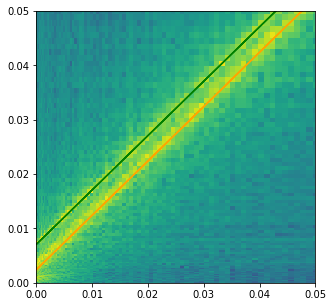

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plt.pcolormesh(KK[oo>0,:][:,kk>0]**2, OO[oo>0,:][:,kk>0]**2, image[oo>0,:][:,kk>0])

plt.plot(kk2, omega(kk2, *popt1), 'g-', label='fit: m=%5.2f'%popt1[-1])#a=%5.3f, m=%5.3f' % tuple(popt1))
plt.plot(kkkk2, omega(kkkk2, *popt3), color='orange', linestyle='-', label='fit: m=%5.2f'%popt3[-1])#a=%5.3f, m=%5.3f' % tuple(popt2))

ax.set_xlim((0,0.05))
ax.set_ylim((0,0.05))

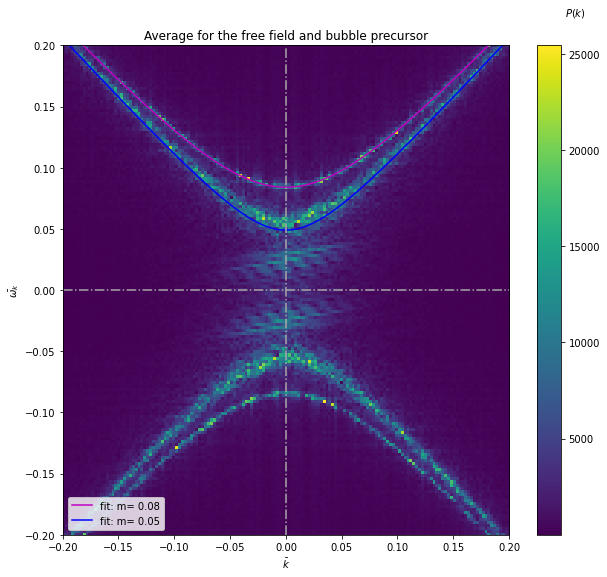

In [20]:
image = np.sqrt(np.mean(samples, axis=0))

fig, ax = plt.subplots(1, 1, figsize=(10, 9))
im = ax.imshow(image, aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])
clb = plt.colorbar(im, ax = ax)
clb.set_label(r'$P(k)$', labelpad=-25, y=1.08, rotation=0)
ax.set_xlabel(r'$\bar{k}$')
ax.set_ylabel(r'$\bar{\omega_k}$')
ax.set_title('Average for the free field and bubble precursor')

ax.plot(kk, np.sqrt(omega(kk**2,*popt1)), color='m', label='fit: m=%5.2f'%popt1[-1])
ax.plot(kk, np.sqrt(omega(kk**2,*popt3)), color='b', label='fit: m=%5.2f'%popt3[-1])    

ax.set_xlim(-0.2,0.2)
ax.set_ylim(-0.2,0.2)
plt.axvline(0, color='darkgray', ls='-.')
plt.axhline(0, color='darkgray', ls='-.')
plt.legend()

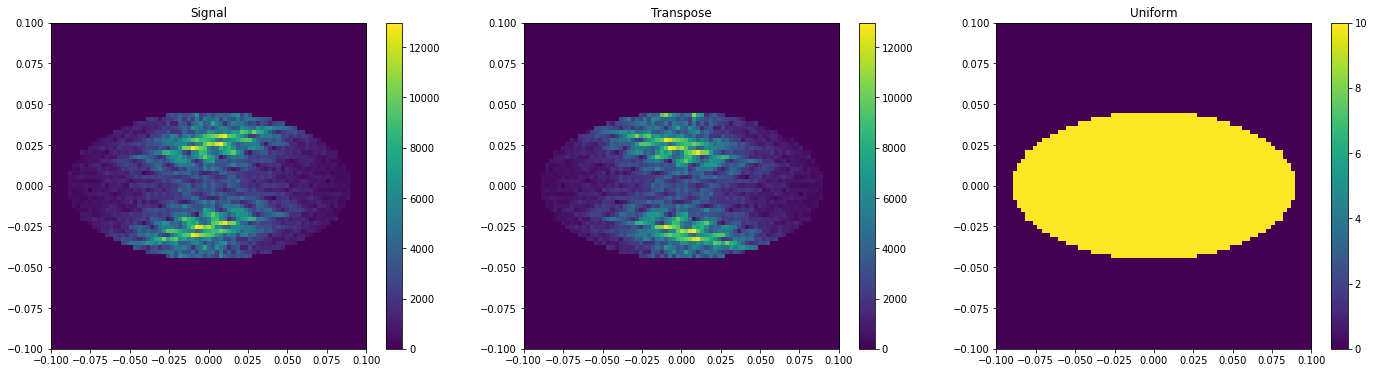

In [21]:
vec_data = [freefield, bubble, oscillon]
choose = -1

p1=0.5
p2=0.25
p3=0.18
coords = ((KK/p1)**2 + (OO/p2)**2 <= p3**2) #& (OO > 0) #& (KK > 0)
window = [image*coords, image[::-1]*coords, 10*coords]

spectralFiltered = np.fft.fftshift(np.fft.fft2(vec_data[choose]))*window

#title_list = [r'Signal', r'$\phi(k)$', r'Filtered $\phi(k)$']
#plot_data = [window, np.log(np.abs(np.fft.fftshift(np.fft.fft2(vec_data[choose])))**2), np.log(np.abs(spectralFiltered)**2.)]
title_list = ['Signal', 'Transpose', 'Uniform']
plot_data = window
fig, ax = plt.subplots(1, 3, figsize=(24, 6))
for i in range(len(ax)):
    im = ax[i].imshow(plot_data[i], aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])#, vmin=0)
    clb = plt.colorbar(im, ax = ax[i])
    ax[i].set_xlim(-0.1,0.1)
    ax[i].set_ylim(-0.1,0.1)
    ax[i].set_title(title_list[i])

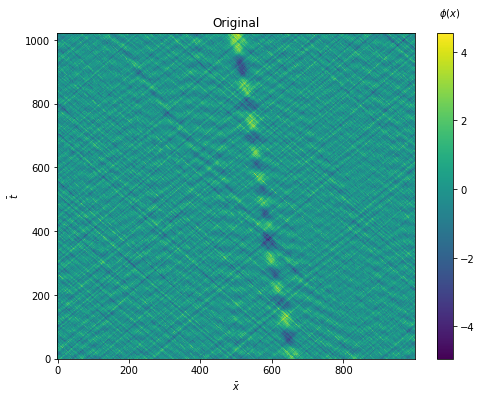

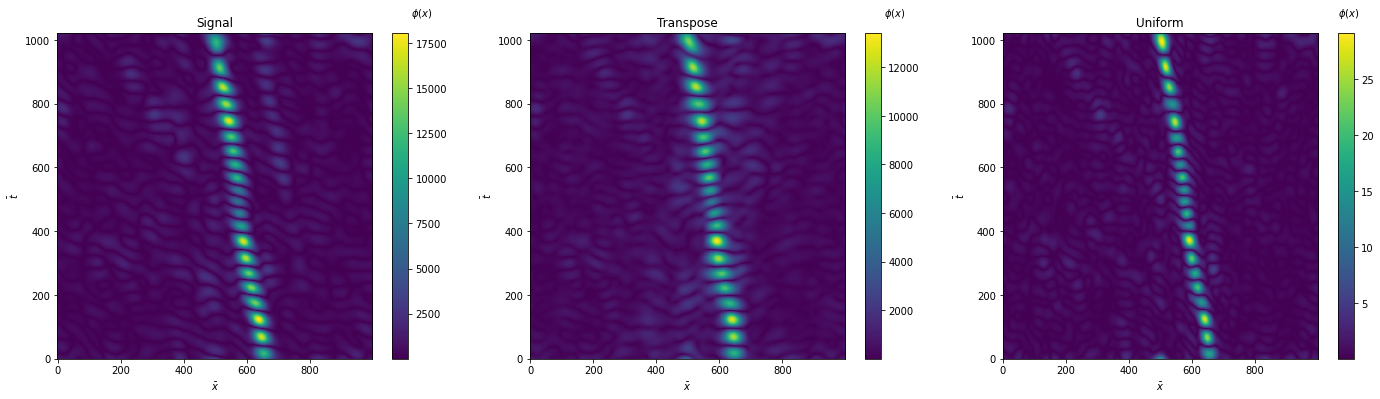

In [23]:
filtered = [np.fft.ifft2(jj) for jj in spectralFiltered]#/bN/bT
#filtered = scs.convolve2d(vec_data[choose], signal)
plot_data = np.array([np.sqrt(np.abs(jj)**2.) for jj in filtered])

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
im = ax.imshow(vec_data[choose], aspect='auto', interpolation='none', origin='lower')
clb = plt.colorbar(im, ax = ax)
clb.set_label(r'$\phi(x)$', labelpad=-25, y=1.08, rotation=0)
ax.set_xlabel(r'$\bar{x}$')
ax.set_ylabel(r'$\bar{t}$')
ax.set_title('Original')

#title_list = ['Original', 'Filtered']
fig, ax = plt.subplots(1, len(plot_data), figsize=(len(plot_data)*8, 6))
for i in range(len(ax)):
    im = ax[i].imshow(plot_data[i], aspect='auto', interpolation='none', origin='lower')
    clb = plt.colorbar(im, ax = ax[i])
    clb.set_label(r'$\phi(x)$', labelpad=-25, y=1.08, rotation=0)
    ax[i].set_xlabel(r'$\bar{x}$')
    ax[i].set_ylabel(r'$\bar{t}$')
    ax[i].set_title(title_list[i])

### Average Oscillon Signal from all Deboosted Thin Wall Bubble Precursors 

<ipython-input-24-6eb651115fd0>:40: RuntimeWarning: divide by zero encountered in log
  im = ax[0].imshow(np.log(bubblePS), aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])


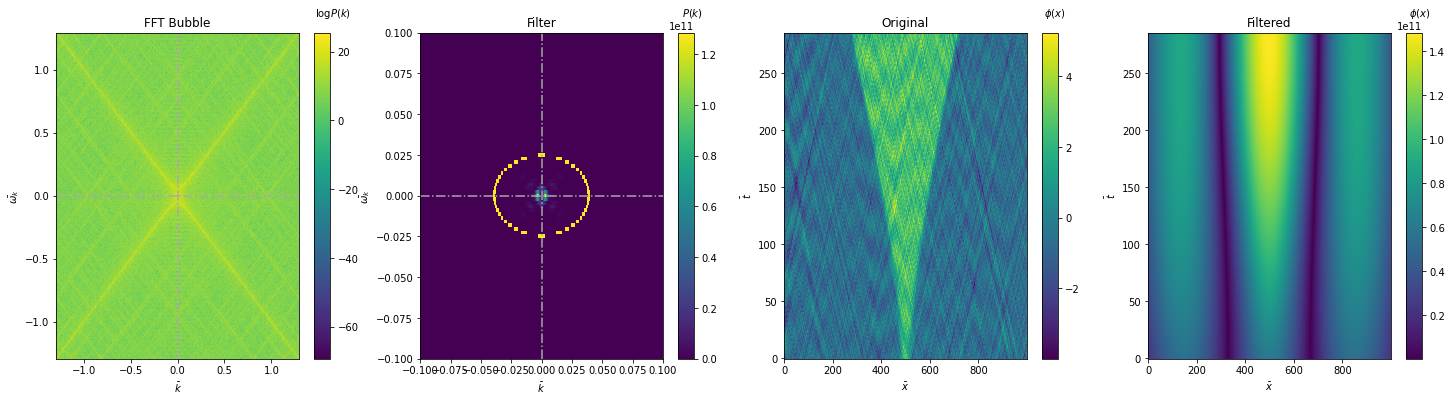

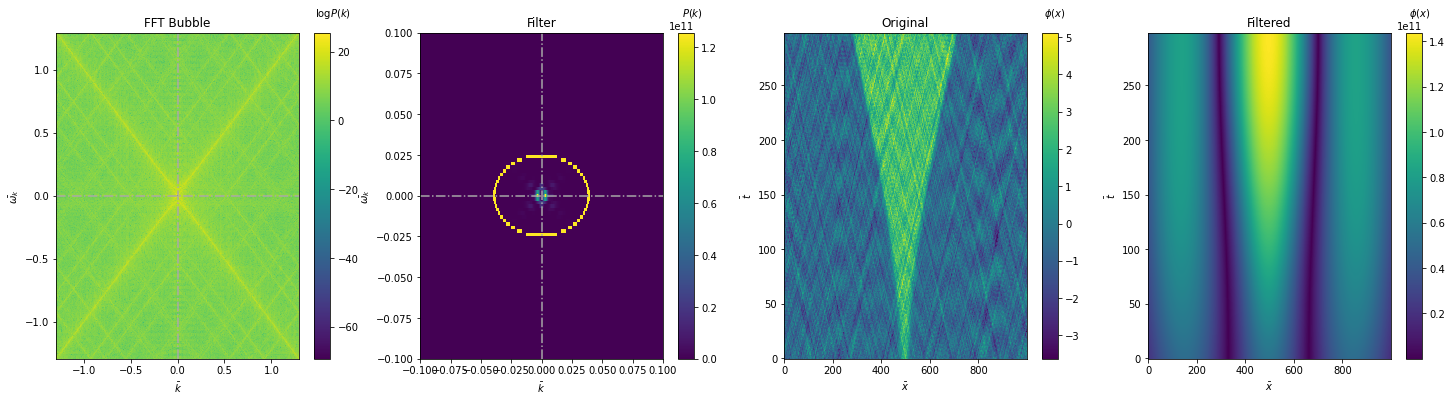

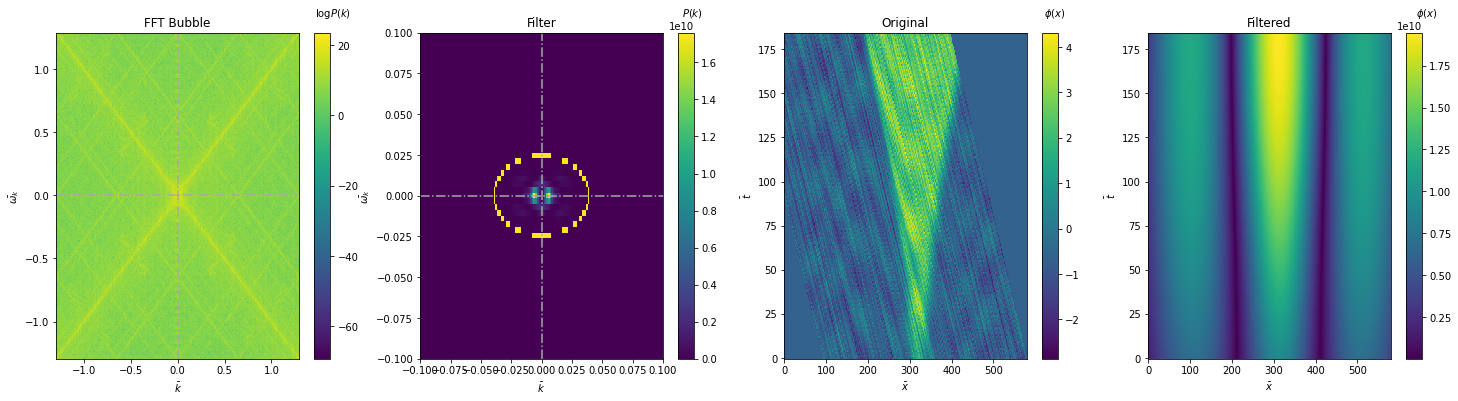

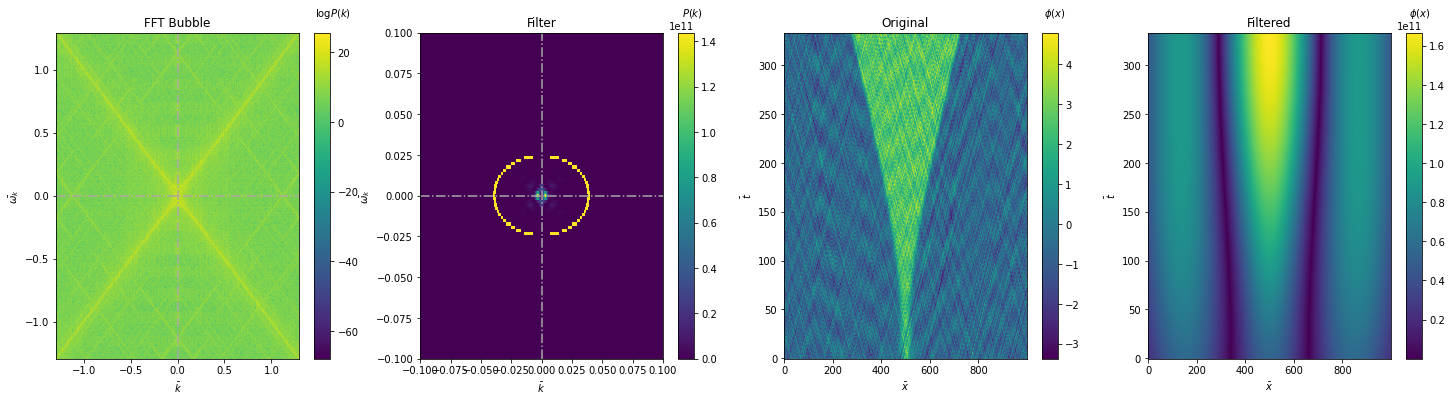

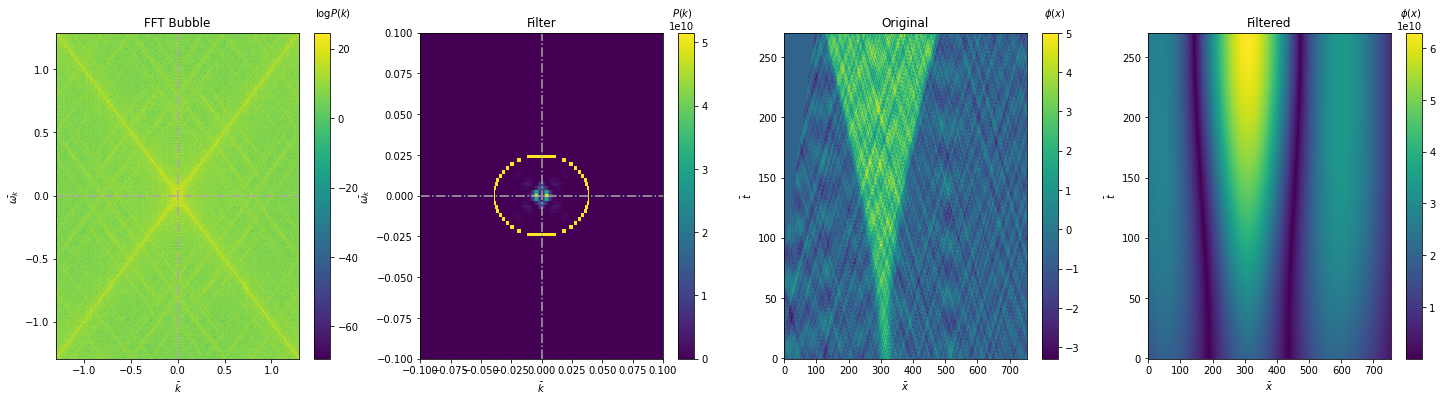

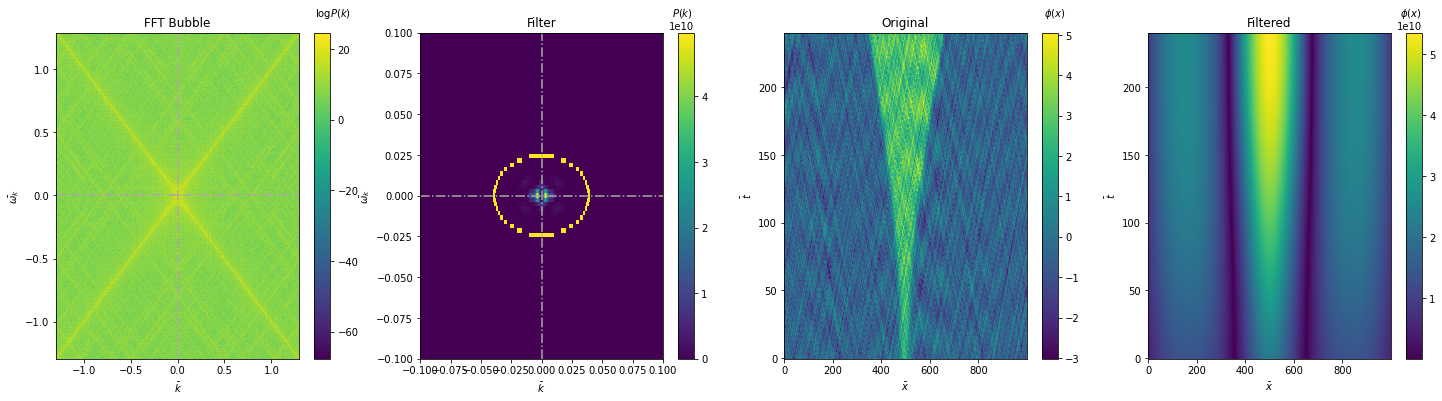

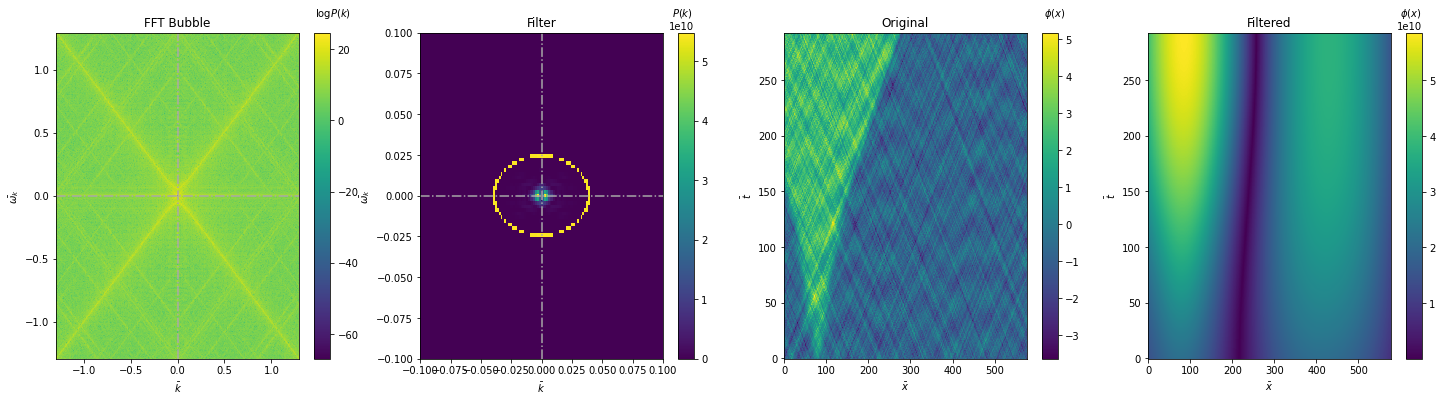

In [24]:
p1=0.4#0.4
p2=0.25#0.25
p3=0.1#0.18
step = 10

if True:
    list_window = []
    for bubble in newBubbleData[::step]:
        bubble = bubble[time_at_fraction(bubble, 0.1, 4):time_at_fraction(bubble, 0.5, 4)]
        bubble = bubble-np.mean(bubble)
        bT, bN = bubble.shape

        extension = np.zeros(bubble.shape)
        extension2 = np.concatenate((extension, extension, extension), axis=1)
        # make rhombus
        bubble = np.concatenate((extension2, np.concatenate((extension, bubble, extension), axis=1), np.concatenate((extension, bubble[::-1], extension), axis=1), extension2), axis=0)
        # extend by zero matrices
#        bubble = np.concatenate((extension2, np.concatenate((extension, bubble, extension), axis=1), extension2), axis=0)

        bT2, bN2 = bubble.shape
        bubblePS = np.abs(np.fft.fftshift(np.fft.fft2(bubble)))**2.
        kk = np.fft.fftshift(np.fft.fftfreq(bN2,d=dx))
        oo = np.fft.fftshift(np.fft.fftfreq(bT2,d=dtout))
        KK, OO = np.meshgrid(kk,oo)

        coords = ((KK/p1)**2 + (OO/p2)**2 <= p3**2)
        # filter from signal
        window = bubblePS*coords
        # point spread functionish
#        window = gaussian_filter(1.*coords, sigma=5)
#        cdss = np.meshgrid(np.asarray([i[0] for i in np.argwhere((-0.1<oo)&(oo<0.1))]), np.asarray([i[0] for i in np.argwhere((-0.1<kk)&(kk<0.1))]))
        list_window.append(window)#[cdss])
    
        bubble = 
        filtered = np.sqrt(np.abs(np.fft.ifft2(np.fft.fftshift(np.fft.fft2(bubble))*window))**2.)[bT:2*bT, bN:2*bN]
        bubblePS = np.abs(np.fft.fftshift(np.fft.fft2(bubble)))**2.
        bubble = bubble[bT:2*bT, bN:2*bN]

        fig, ax = plt.subplots(1, 4, figsize=(25, 6))
    #    im = ax[0].imshow(bubblePS + (bubblePS*0.+np.amax(bubblePS))*(((p3-0.005)**2 <= (KK/p1)**2 + (OO/p2)**2) & ((KK/p1)**2 + (OO/p2)**2 <= p3**2)), aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])
        im = ax[0].imshow(np.log(bubblePS), aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])
        clb = plt.colorbar(im, ax = ax[0])
        clb.set_label(r'$\log P(k)$', labelpad=-25, y=1.08, rotation=0)

        im = ax[1].imshow(window + (window*0.+np.amax(window))*(((p3-0.005)**2 <= (KK/p1)**2 + (OO/p2)**2) & ((KK/p1)**2 + (OO/p2)**2 <= p3**2)), aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])
        clb = plt.colorbar(im, ax = ax[1])
        clb.set_label(r'$P(k)$', labelpad=-25, y=1.08, rotation=0)
        [ax[i].set_xlabel(r'$\bar{k}$') for i in range(len(ax)//2)]
        [ax[i].set_ylabel(r'$\bar{\omega_k}$') for i in range(len(ax)//2)]
        ax[1].set_xlim(-0.1,0.1)
        ax[1].set_ylim(-0.1,0.1)
        [ax[i].axvline(0, color='darkgray', ls='-.') for i in range(len(ax)//2)]
        [ax[i].axhline(0, color='darkgray', ls='-.') for i in range(len(ax)//2)]

        im1 = ax[2].imshow(bubble, aspect='auto', interpolation='none', origin='lower')
        clb = plt.colorbar(im1, ax = ax[2])
        clb.set_label(r'$\phi(x)$', labelpad=-25, y=1.08, rotation=0)
        im2 = ax[3].imshow(filtered, aspect='auto', interpolation='none', origin='lower')
        clb = plt.colorbar(im2, ax = ax[3])
        clb.set_label(r'$\phi(x)$', labelpad=-25, y=1.08, rotation=0)
        [ax[i].set_xlabel(r'$\bar{x}$') for i in range(len(ax)//2, len(ax))]
        [ax[i].set_ylabel(r'$\bar{t}$') for i in range(len(ax)//2, len(ax))]
        [ax[i].set_title(['FFT Bubble', 'Filter', 'Original', 'Filtered'][i]) for i in range(len(ax))]
        plt.show()

### Check Longevity of Oscillon 

In [25]:
def plot_2dsim(simulation, sim):
    print(simulation.shape)
    fig, ax = plt.subplots(1, 1, figsize = (7, 5))
    im = ax.imshow(simulation, aspect='auto', interpolation='none', origin='lower', extent=[0, np.sqrt(4*nu)*len(simulation[0])*dx, 0, np.sqrt(4*nu)*len(simulation)*dtout])
    clb = plt.colorbar(im, ax = ax)
    clb.set_label(r'$\phi(t, r)$', labelpad=-28, y=1.08, rotation=0)
    ax.set_title('Simulation '+str(sim))
    ax.set(xlabel = r'$\phi_0^{-1} \sqrt{V_0} r$', ylabel = r'$\phi_0^{-1} \sqrt{V_0} t$')
    plt.show()
    return

def plot_all(precursorPS, window, precursor, filtered, limit):
    fig, ax = plt.subplots(1, 4, figsize=(25, 6))
    im = ax[0].imshow(np.log(precursorPS), aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])
    clb = plt.colorbar(im, ax = ax[0])
    clb.set_label(r'$\log P(k)$', labelpad=-25, y=1.08, rotation=0)

    im = ax[1].imshow(window + (window*0.+np.amax(window))*(((p3-0.005)**2 <= (KK/p1)**2 + (OO/p2)**2) & ((KK/p1)**2 + (OO/p2)**2 <= p3**2)), aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])
    clb = plt.colorbar(im, ax = ax[1])
    clb.set_label(r'$P(k)$', labelpad=-25, y=1.08, rotation=0)
    [ax[i].set_xlabel(r'$\bar{k}$') for i in range(len(ax)//2)]
    [ax[i].set_ylabel(r'$\bar{\omega_k}$') for i in range(len(ax)//2)]
    ax[1].set_xlim(-limit,limit)
    ax[1].set_ylim(-limit,limit)
    [ax[i].axvline(0, color='darkgray', ls='-.') for i in range(len(ax)//2)]
    [ax[i].axhline(0, color='darkgray', ls='-.') for i in range(len(ax)//2)]

    im1 = ax[2].imshow(precursor, aspect='auto', interpolation='none', origin='lower')
    clb = plt.colorbar(im1, ax = ax[2])
    clb.set_label(r'$\phi(x)$', labelpad=-25, y=1.08, rotation=0)
    im2 = ax[3].imshow(filtered, aspect='auto', interpolation='none', origin='lower')
    clb = plt.colorbar(im2, ax = ax[3])
    clb.set_label(r'$\phi(x)$', labelpad=-25, y=1.08, rotation=0)
    [ax[i].set_xlabel(r'$\bar{x}$') for i in range(len(ax)//2, len(ax))]
    [ax[i].set_ylabel(r'$\bar{t}$') for i in range(len(ax)//2, len(ax))]
    [ax[i].set_title(['FFT Bubble Precursor', 'Filter', 'Original', 'Filtered'][i]) for i in range(len(ax))]
    plt.show()
    return

In [2]:
bubbles_file = lambda sim: '/gpfs/dpirvu/oscillons/bubble_sim'+str(sim)+'_for_phi0{:.4f}'.format(phi0)+'_lambda'+str(int(lamb))+'_len{:.4f}'.format(lenLat)+'_x'+str(nLat)+'.npy'

for sim in range(12, 13):
    if os.path.exists(bubbles_file(sim)):
        simulation = np.load(bubbles_file(sim))[0]
#        simulation = simulation[:, int(2*simulation.shape[1]/3):simulation.shape[1]]
        plot_2dsim(simulation, sim)
        
        precursor = simulation[:200]
        precursor = precursor-np.mean(precursor)
        bT, bN = precursor.shape

        extension = np.zeros(precursor.shape)
        extension2 = np.concatenate((extension, extension, extension), axis=1)
        # extend by zero matrices
        precursor = np.concatenate((extension2, np.concatenate((extension, precursor, extension), axis=1), extension2), axis=0)

        bT2, bN2 = precursor.shape
        precursorPS = np.abs(np.fft.fftshift(np.fft.fft2(precursor)))**2.
        kk = np.fft.fftshift(np.fft.fftfreq(bN2,d=dx))
        oo = np.fft.fftshift(np.fft.fftfreq(bT2,d=dtout))
        KK, OO = np.meshgrid(kk,oo)

        p1=0.4#0.4
        p2=0.25#0.25
        p3=0.35#0.18
        coords = ((KK/p1)**2 + (OO/p2)**2 <= p3**2)
        # filter from signal
        window = precursorPS*coords
        # point spread functionish
#        window = gaussian_filter(1.*coords, sigma=5)
    
        filtered = np.sqrt(np.abs(np.fft.ifft2(np.fft.fftshift(np.fft.fft2(precursor))*window))**2.)[bT:2*bT, bN:2*bN]
        precursorPS = np.abs(np.fft.fftshift(np.fft.fft2(precursor)))**2.
        precursor = precursor[bT:2*bT, bN:2*bN]
        
        plot_all(precursorPS, window, precursor, filtered, limit=0.2)

NameError: name 'os' is not defined

In [28]:
import os
import sys
module_path = sys.path.append('/home/dpirvu/.local/lib/python3.8/site-packages/')
module_path = sys.path.append('/home/dpirvu/.local/bin/')
for i in sys.path:
    i = i.replace("8", "7")
    if i not in sys.path:
        sys.path.append(i)
        print(i)

from celluloid import Camera

/cm/shared/apps/conda-environments/python37/lib/python37.zip
/cm/shared/apps/conda-environments/python37/lib/python3.7
/cm/shared/apps/conda-environments/python37/lib/python3.7/lib-dynload
/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages
/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/IPython/extensions
/home/dpirvu/.local/lib/python3.7/site-packages/


1636


NameError: name 'Camera' is not defined

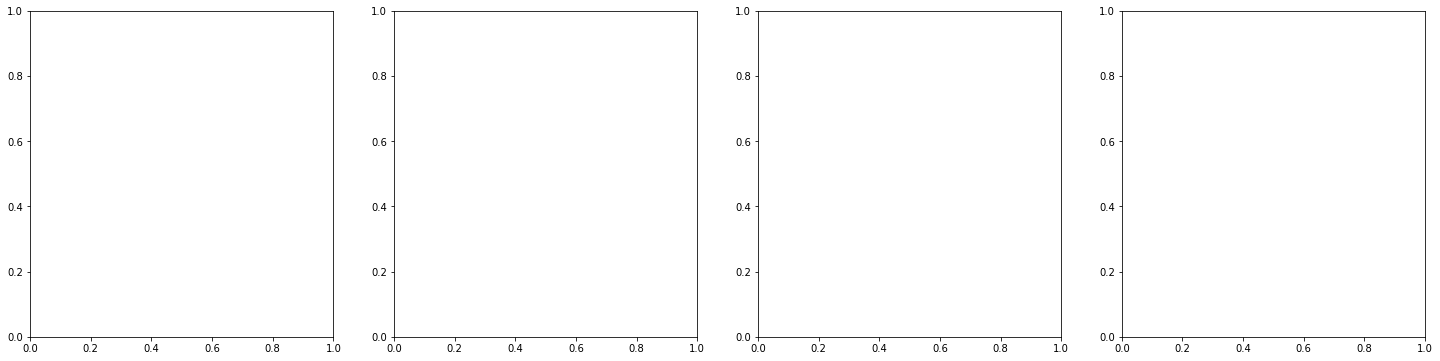

In [26]:
bubbles_file = lambda sim: '/gpfs/dpirvu/oscillons/bubble_sim'+str(sim)+'_for_phi0{:.4f}'.format(phi0)+'_lambda'+str(int(lamb))+'_len{:.4f}'.format(lenLat)+'_x'+str(nLat)+'.npy'
sim = 12
simulation = np.load(bubbles_file(sim))[0]
simulation = simulation[-int(simulation.shape[0]/3):-500]
print(len(simulation))
limit = 0.15
p1=0.4#0.4
p2=0.25#0.25
p3=0.4#0.18

fig, ax = plt.subplots(1, 4, figsize=(25, 6))
camera = Camera(fig)
[ax[i].set_xlabel(r'$\bar{x}$') for i in range(len(ax)//2, len(ax))]
[ax[i].set_ylabel(r'$\bar{t}$') for i in range(len(ax)//2, len(ax))]
[ax[i].set_title(['FFT Bubble Precursor', 'Filter', 'Original', 'Filtered'][i]) for i in range(len(ax))]
[ax[i].set_xlabel(r'$\bar{k}$') for i in range(len(ax)//2)]
[ax[i].set_ylabel(r'$\bar{\omega_k}$') for i in range(len(ax)//2)]
ax[1].set_xlim(-limit,limit)
ax[1].set_ylim(-limit,limit)
#[ax[i].axvline(0, color='darkgray', ls='-.') for i in range(len(ax)//2)]
#[ax[i].axhline(0, color='darkgray', ls='-.') for i in range(len(ax)//2)]

for amin, amax in zip(np.arange(0, len(simulation), 50), np.arange(100, len(simulation), 50)):
    print(amin, amax)
    precursor = simulation[amin:amax]
    precursor = precursor-np.mean(precursor)
    bT, bN = precursor.shape

    extension = np.zeros(precursor.shape)
    extension2 = np.concatenate((extension, extension, extension), axis=1)
    # extend by zero matrices
    precursor = np.concatenate((extension2, np.concatenate((extension, precursor, extension), axis=1), extension2), axis=0)

    precursorPS = np.abs(np.fft.fftshift(np.fft.fft2(precursor)))**2.
    kk = np.fft.fftshift(np.fft.fftfreq(precursor.shape[1],d=dx))
    oo = np.fft.fftshift(np.fft.fftfreq(precursor.shape[0],d=dtout))
    KK, OO = np.meshgrid(kk,oo)
    coords = ((KK/p1)**2 + (OO/p2)**2 <= p3**2)
    
    # filter from signal
    window = precursorPS*coords
    # point spread functionish
#    window = gaussian_filter(1.*coords, sigma=5)
    
    filtered = np.sqrt(np.abs(np.fft.ifft2(np.fft.fftshift(np.fft.fft2(precursor))*window))**2.)[bT:2*bT, bN:2*bN]
    precursor = precursor[bT:2*bT, bN:2*bN]

    im = ax[0].imshow(np.log(precursorPS), aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])
    im = ax[1].imshow(window + (window*0.+np.amax(window))*(((p3-0.005)**2 <= (KK/p1)**2 + (OO/p2)**2) & ((KK/p1)**2 + (OO/p2)**2 <= p3**2)), aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])
    im1 = ax[2].imshow(precursor, aspect='auto', interpolation='none', origin='lower')
    im2 = ax[3].imshow(filtered, aspect='auto', interpolation='none', origin='lower')
#    clb = plt.colorbar(im, ax = ax); clb.set_label(r'$\phi(x)$', labelpad=-25, y=1.08, rotation=0)
    fig.suptitle(f't = {amin, amax}')
    camera.snap()

animation = camera.animate(interval = 400);
animation.save('/home/dpirvu/thin_wall_average_bubble/ocillon_evol3.gif', writer = 'imagemagick')

### What does bubble inside look like 

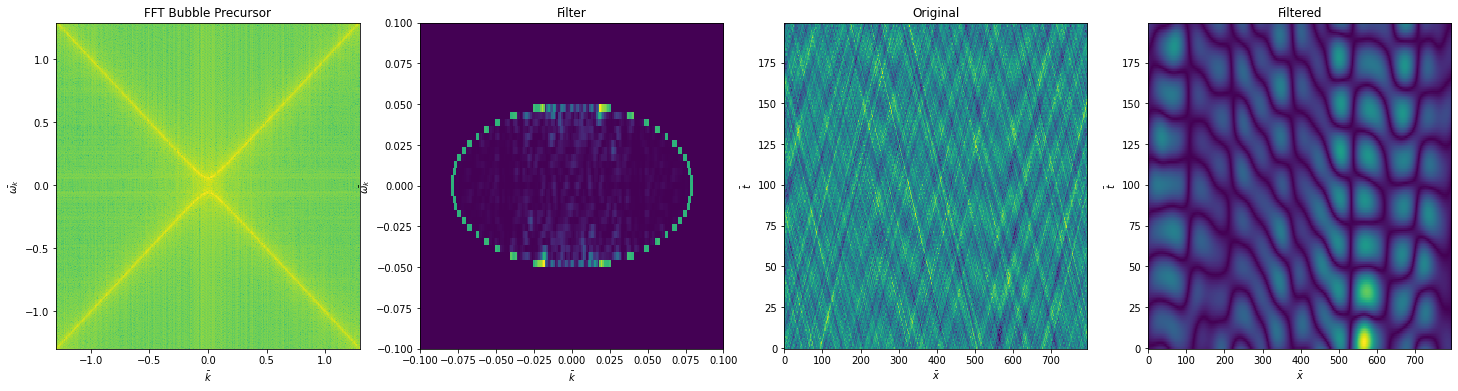

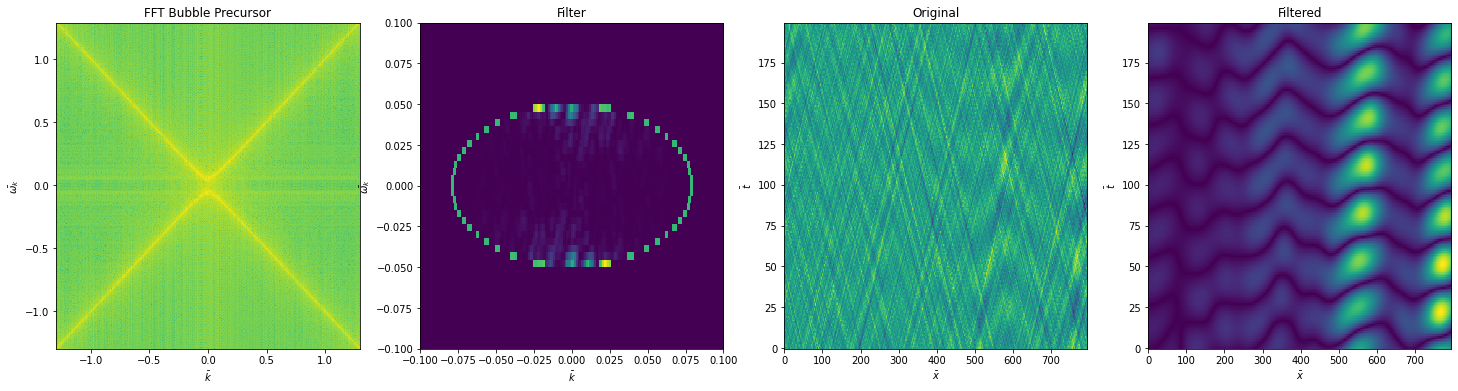

In [27]:
bubbles_file = lambda sim: '/gpfs/dpirvu/oscillons/bubble_sim'+str(sim)+'_for_phi0{:.4f}'.format(phi0)+'_lambda'+str(int(lamb))+'_len{:.4f}'.format(lenLat)+'_x'+str(nLat)+'.npy'
sim = 12
simulation = np.load(bubbles_file(sim))[0]
limit = 0.1
p1=0.4#0.4
p2=0.25#0.25
p3=0.2#0.18

listPS = []
for precursor in [simulation[:200, 3000:], simulation[-200:, 3100:-200]]:
    fig, ax = plt.subplots(1, 4, figsize=(25, 6))
    [ax[i].set_xlabel(r'$\bar{x}$') for i in range(len(ax)//2, len(ax))]
    [ax[i].set_ylabel(r'$\bar{t}$') for i in range(len(ax)//2, len(ax))]
    [ax[i].set_title(['FFT Bubble Precursor', 'Filter', 'Original', 'Filtered'][i]) for i in range(len(ax))]
    [ax[i].set_xlabel(r'$\bar{k}$') for i in range(len(ax)//2)]
    [ax[i].set_ylabel(r'$\bar{\omega_k}$') for i in range(len(ax)//2)]
    ax[1].set_xlim(-limit,limit)
    ax[1].set_ylim(-limit,limit)
    #[ax[i].axvline(0, color='darkgray', ls='-.') for i in range(len(ax)//2)]
    #[ax[i].axhline(0, color='darkgray', ls='-.') for i in range(len(ax)//2)]

    precursor = precursor-np.mean(precursor)
    bT, bN = precursor.shape

    extension = np.zeros(precursor.shape)
    extension2 = np.concatenate((extension, extension, extension), axis=1)
    # extend by zero matrices
    precursor = np.concatenate((extension2, np.concatenate((extension, precursor, extension), axis=1), extension2), axis=0)
    
    precursorPS = np.abs(np.fft.fftshift(np.fft.fft2(precursor)))**2.
    listPS.append(precursorPS)
    kk = np.fft.fftshift(np.fft.fftfreq(precursor.shape[1],d=dx))
    oo = np.fft.fftshift(np.fft.fftfreq(precursor.shape[0],d=dtout))
    KK, OO = np.meshgrid(kk,oo)
    coords = ((KK/p1)**2 + (OO/p2)**2 <= p3**2)

    # filter from signal
    window = precursorPS*coords
    # point spread functionish
    #window = gaussian_filter(1.*coords, sigma=5)

    filtered = np.sqrt(np.abs(np.fft.ifft2(np.fft.fftshift(np.fft.fft2(precursor))*window))**2.)[bT:2*bT, bN:2*bN]
    precursor = precursor[bT:2*bT, bN:2*bN]

    im = ax[0].imshow(np.log(precursorPS), aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])
    im = ax[1].imshow(window + (window*0.+np.amax(window))*(((p3-0.005)**2 <= (KK/p1)**2 + (OO/p2)**2) & ((KK/p1)**2 + (OO/p2)**2 <= p3**2)), aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])
    im1 = ax[2].imshow(precursor, aspect='auto', interpolation='none', origin='lower')
    im2 = ax[3].imshow(filtered, aspect='auto', interpolation='none', origin='lower')
    #clb = plt.colorbar(im, ax = ax); clb.set_label(r'$\phi(x)$', labelpad=-25, y=1.08, rotation=0)
    plt.show()

listPS.append(np.mean(listPS, axis=0))

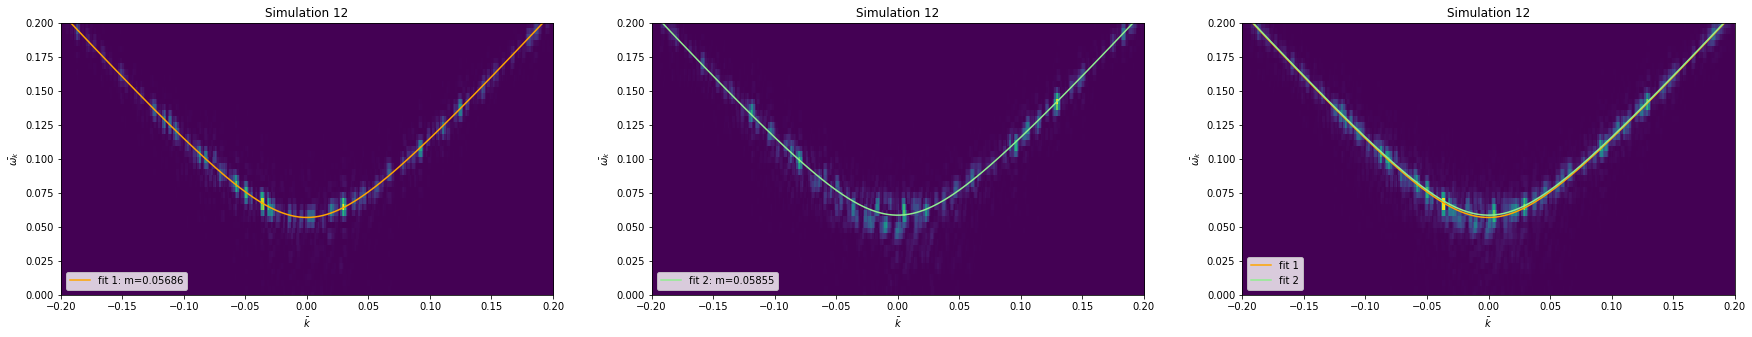

In [67]:
limit = 0.2
popt = []
cols = ['orange', 'lightgreen']
fig, ax = plt.subplots(1, len(listPS), figsize = (10*len(listPS), 5))
for jj in range(len(listPS)):
    kk = np.fft.fftshift(np.fft.fftfreq(listPS[jj].shape[1],d=dx))
    oo = np.fft.fftshift(np.fft.fftfreq(listPS[jj].shape[0],d=dtout))
    KK, OO = np.meshgrid(kk,oo)
    coords = ((KK/p1)**2 + (OO/p2)**2 <= p3**2)

    # pairs (\omega_k, k)
    if jj < len(listPS)-1:
        maxVal = np.mean(listPS[jj]) + 5*np.std(listPS[jj])
        osccoords = np.argwhere(listPS[jj]>maxVal)
        popt.append(sco.curve_fit(omega, kk[osccoords[:,1]]**2., oo[osccoords[:,0]]**2.)[0])
        ax[jj].plot(kk, np.sqrt(omega(kk**2,*popt[-1])), color=cols[len(popt)-1], label='fit '+str(len(popt))+': m=%5.5f'%popt[-1][-1])
    else:
        [ax[jj].plot(kk, np.sqrt(omega(kk**2,*popt[ii])), color=cols[ii], label='fit '+str(ii+1)) for ii in range(len(popt))]

    im = ax[jj].imshow(listPS[jj], aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])
#    clb = plt.colorbar(im, ax = ax[jj]); clb.set_label(r'$\phi(t, r)$', labelpad=-28, y=1.08, rotation=0)
    ax[jj].set_xlim(-limit, limit)
    ax[jj].set_ylim(0, limit)
    ax[jj].set_title('Simulation '+str(sim))
[ax[i].set_xlabel(r'$\bar{k}$') for i in range(len(ax))]
[ax[i].set_ylabel(r'$\bar{\omega_k}$') for i in range(len(ax))]
#[ax[i].axvline(0, color='darkgray', ls='-.') for i in range(len(ax))]
#[ax[i].axhline(0, color='darkgray', ls='-.') for i in range(len(ax))]
[ax[i].legend() for i in range(len(ax))]